# Plot MPC Control Results

In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import sys; sys.path.append(2*'../')
from src import *
import matplotlib.pyplot as plt
from torch import cos, sin, sign, norm

# device = torch.device('cuda:0')
device=torch.device('cpu')

import matplotlib.pyplot as plt


In [2]:
# print(max(torch.load('data/trajectory_rk4.pt')[:, 8]))
# experiments = ['hypereuler', 'euler', 'midpoint', 'rk4']
experiments = ['MidpointInaccurate', 'MultistageHypersolver', 'EulerAccurate', 'MidpointAccurate']
colors = {'midpoint_inaccurate': 'tab:red', 'multistage_hs': 'tab:orange', 'euler_accurate':'tab:green', 'midpoint_accurate': 'tab:purple'}
labels = {'midpoint_inaccurate': 'RK4 (inaccurate dynamics)', 'multistage_hs': 'Multistage HyperSolver (inaccurate dynamics)', 'euler_accurate':'Euler (accurate dynamics)', 'midpoint_accurate': 'RK4 (accurate dynamics)'}

In [3]:
experiments = ['MidpointInaccurate', 'MultistageHypersolver', 'EulerAccurate', 'MidpointAccurate']
num = 11 # change this

trajectories_mp_inac, controls_mp_inac, losses_mp_inac = [], [], []
trajectories_hs, controls_hs, losses_hs = [], [], []
trajectories_eu_ac, controls_eu_ac, losses_eu_ac = [], [], []
trajectories_mp_ac, controls_mp_ac, losses_mp_ac = [], [], []

for n in range(1, num):
    name = experiments[0]
    trajectories_mp_inac.append(torch.load('data/{}_traj_{}.pt'.format(name, n)))
    controls_mp_inac.append(torch.load('data/{}_controls_{}.pt'.format(name, n)))        

for n in range(1, num):
    name = experiments[1]
    trajectories_hs.append(torch.load('data/{}_traj_{}.pt'.format(name, n)))
    controls_hs.append(torch.load('data/{}_controls_{}.pt'.format(name, n)))       

for n in range(1, num):
    name = experiments[2]
    trajectories_eu_ac.append(torch.load('data/{}_traj_{}.pt'.format(name, n)))
    controls_eu_ac.append(torch.load('data/{}_controls_{}.pt'.format(name, n)))      

for n in range(1, num):
    name = experiments[3]
    trajectories_mp_ac.append(torch.load('data/{}_traj_{}.pt'.format(name, n)))
    controls_mp_ac.append(torch.load('data/{}_controls_{}.pt'.format(name, n)))        


### Outlier removal
Why do we remove outliers? Since MPC is very sensitive on the cost function, it may be possible that some optimizations fails to converge (also because of the `tanh` layer in `BoxConstrainedController`, see note in `controllers.py`). This seems to be due also to the complexity of the vector field, which has discontinuities due to frictions. Hence we remove outliers for better plotting. We do notice a trend: usually there are no outliers in the `Multi-stage Hypersolver` case, indicating that MPC can better optimize with our approach anyways.

In [4]:
def outlier_removal(traj, controls):
    traj_new = []
    controls_new = []
    for t, c in zip(traj, controls):
        if abs(t[-1, 2].detach().item()) < 0.5:
            traj_new.append(t); controls_new.append(c)
    
    print("Trajectories without outliers: {} / {}".format(len(traj_new), len(traj)))
    return traj_new, controls_new

trajectories_hs, controls_hs = outlier_removal(trajectories_hs, controls_hs)
trajectories_mp_inac, controls_mp_inac = outlier_removal(trajectories_mp_inac, controls_mp_inac)
trajectories_eu_ac, controls_eu_ac = outlier_removal(trajectories_eu_ac, controls_eu_ac)
trajectories_mp_ac, controls_mp_ac = outlier_removal(trajectories_mp_ac, controls_mp_ac)

Trajectories without outliers: 10 / 10
Trajectories without outliers: 7 / 10
Trajectories without outliers: 10 / 10
Trajectories without outliers: 10 / 10


In [5]:
target = torch.Tensor([0, 0, 0, 0])
from statistics import mean, stdev

def target_distance(traj, target=target):
    # only on dimension
    return torch.norm(traj[-1, 0] - target[0])

err_hs = []
for t in trajectories_hs:
    # print(target_distance(t))
    err_hs.append(target_distance(t).item())

print('Multistage Hypersolver mean +- std:', mean(err_hs), stdev(err_hs))

err_mp_inac = []
for t in trajectories_mp_inac:
    # print(target_distance(t))
    err_mp_inac.append(target_distance(t).item())
print('Midpoint inaccurate dynamics mean +- std:', mean(err_mp_inac), stdev(err_mp_inac))

err_eu_ac = []
for t in trajectories_eu_ac:
    # print(target_distance(t))
    err_eu_ac.append(target_distance(t).item())
print('Euler accurate dynamics mean +- std:', (mean(err_eu_ac)), stdev(err_eu_ac))

err_mp_ac = []
for t in trajectories_mp_ac:
    # print(target_distance(t))
    err_mp_ac.append(target_distance(t).item())

print('Midpoint accurate dynamics mean +- std:', mean(err_mp_ac), stdev(err_mp_ac))

Multistage Hypersolver mean +- std: 0.07784561756998301 0.03014963903742135
Midpoint inaccurate dynamics mean +- std: 0.3970922448539308 0.9771177797747029
Euler accurate dynamics mean +- std: 0.06315497742034495 0.03453611794009653
Midpoint accurate dynamics mean +- std: 0.021965796453878285 0.0177146366086006


In [6]:
experiments = ['MidpointInaccurate', 'MultistageHypersolver', 'EulerAccurate', 'MidpointAccurate']
colors = {'MidpointInaccurate': 'tab:red', 'MultistageHypersolver': 'tab:orange', 'EulerAccurate':'tab:green', 'MidpointAccurate': 'tab:purple'}
labels = {'MultistageHypersolver': 'RK4 (inaccurate dynamics)', 'MultistageHypersolver': 'Multistage HyperSolver (inaccurate dynamics)', 'EulerAccurate':'Euler (accurate dynamics)', 'MidpointAccurate': 'RK4 (accurate dynamics)'}

Text(0.5, 0.92, 'Trajectories')

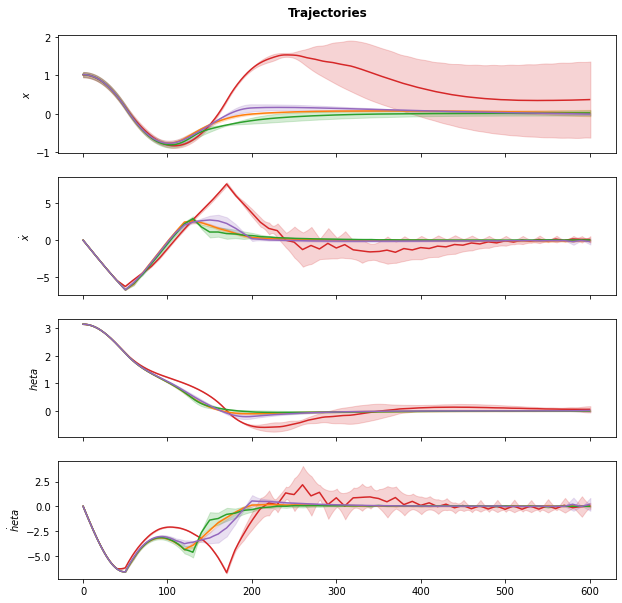

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(10, 10))

axis_labels = ['$x$', '$\dot x$', '$\theta$', '$\dot \theta$']
trajectories = [trajectories_mp_inac, trajectories_hs, trajectories_eu_ac, trajectories_mp_ac]
for exp, traj in zip(experiments, trajectories):
    traj = torch.stack(traj)
    for ax, i, axis_label in zip(axs, range(len(axs)), axis_labels):
        # ax.plot(traj[:, i].meancpu().detach(), color=colors[exp])
        tm, ts = traj[..., i].mean(0).detach(), traj[..., i].std(0).detach()
        t_span = torch.linspace(0, len(tm), len(tm))
        ax.plot(tm, color=colors[exp])
        ax.fill_between(t_span, tm - ts, tm + ts, color=colors[exp], alpha=0.2)
        ax.label_outer()
        ax.set_ylabel(axis_label)

fig.suptitle('Trajectories', y=0.92, fontweight='bold') 

Text(0.5, 0.92, 'Control inputs')

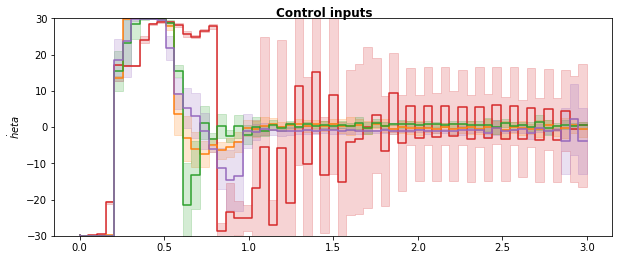

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

axis_labels = ['$x$', '$\dot x$', '$\theta$', '$\dot \theta$']
controls = [controls_mp_inac, controls_hs, controls_eu_ac, controls_mp_ac]
for exp, control in zip(experiments, controls):
    control = torch.stack(control).squeeze()
    # ax.plot(traj[:, i].meancpu().detach(), color=colors[exp])
    tm, ts = control.mean(0).detach(), control.std(0).detach()
    t_span = torch.linspace(0, 3, len(tm))
    ax.step(t_span, tm, color=colors[exp])
    ax.fill_between(t_span, tm - ts, tm + ts, color=colors[exp],step='pre', alpha=0.2)
    ax.label_outer()
    ax.set_ylabel(axis_label)
    ax.set_ybound(-30, 30)

fig.suptitle('Control inputs', y=0.92, fontweight='bold')  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


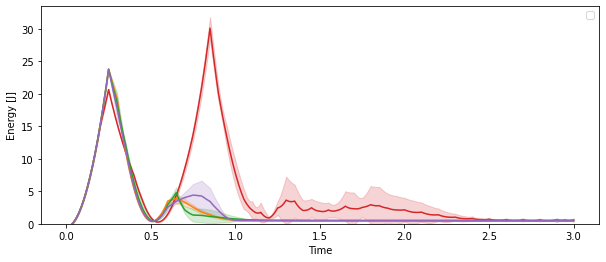

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

controls = [controls_mp_inac, controls_hs, controls_eu_ac, controls_mp_ac]
trajectories = [trajectories_mp_inac, trajectories_hs, trajectories_eu_ac, trajectories_mp_ac]
delta = 10

# Energy plots
system = CartPole(RandConstController)
system.frictioncart = 0.1
system.frictionpole = 0.03
for exp, control, traj in zip(experiments, controls, trajectories):
    control = torch.stack(control).squeeze()
    traj = torch.stack(traj)

    KE = system.kinetic_energy(traj)
    PE = system.potential_energy(traj)
    TE = KE + PE
    te_mean, te_std = TE.mean(0).detach().squeeze(), TE.std(0).detach().squeeze()
    t_span = torch.linspace(0, 3, len(te_mean))
    ax.plot(t_span, te_mean, color=colors[exp])
    ax.fill_between(t_span, te_mean - te_std, te_mean + te_std, color=colors[exp], alpha=0.2)

ax.set_ylim(0)
ax.set_ylabel('Energy [J]')
ax.set_xlabel('Time')
ax.legend()
    

In [10]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Unified plotting

In [11]:
def skip_points(traj, skip=10):
    """Skip trajectory every skip frames to reduce plot dimensions"""
    trajs_reduced = []
    for i in range(int(traj.shape[1]/skip)):
        trajs_reduced.append(traj[:, i*skip,:][None])
    trajs = torch.Tensor(np.stack(trajs_reduced)).squeeze().swapaxes(0,1)
    return trajs


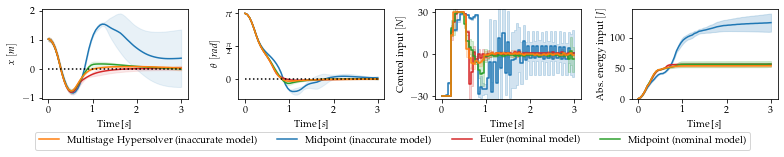

In [19]:
from math import pi as π

experiments = ['MidpointInaccurate', 'EulerAccurate', 'MidpointAccurate', 'MultistageHypersolver']
colors = {'MidpointInaccurate': 'tab:blue', 'MultistageHypersolver': 'tab:orange', 'EulerAccurate':'tab:red', 'MidpointAccurate': 'tab:green'}
labels = {'MidpointInaccurate': 'Midpoint (inaccurate model)', 'MultistageHypersolver': 'Multistage Hypersolver (inaccurate model)', 'EulerAccurate':'Euler (nominal model)', 'MidpointAccurate': 'Midpoint (nominal model)'}
linestyles = {'MidpointInaccurate': '-', 'MultistageHypersolver': '-', 'EulerAccurate':'-', 'MidpointAccurate': '-'}
trajectories = [trajectories_mp_inac, trajectories_eu_ac, trajectories_mp_ac, trajectories_hs]
controls = [controls_mp_inac, controls_eu_ac, controls_mp_ac, controls_hs]

alpha = .1

fig, axs = plt.subplots(1, 4, figsize=(11, 2))

for exp, traj, control in zip(experiments, trajectories, controls):
    # Trajectories
    traj = skip_points(torch.stack(traj))
    
    t_m, t_s = traj.mean(0).detach(), traj.std(0).detach()
    tm0, tm1, tm2, tm3 = t_m[..., 0], t_m[..., 1], t_m[..., 2], t_m[..., 3]
    ts0, ts1, ts2, ts3 = t_s[..., 0], t_s[..., 1], t_s[..., 2], t_s[..., 3]
    t_span = torch.linspace(0, 3, len(tm0))
    axs[0].plot(t_span, tm0, color=colors[exp], label=labels[exp], linestyle=linestyles[exp])
    axs[1].plot(t_span, tm2, color=colors[exp], label=labels[exp], linestyle=linestyles[exp])
    axs[0].fill_between(t_span, tm0 - ts0, tm0 + ts0, alpha=alpha,  color=colors[exp])
    axs[1].fill_between(t_span, tm2 - ts2, tm2 + ts2, alpha=alpha,  color=colors[exp])

    # Controls
    control = torch.stack(control).squeeze()
    cmean, cstd = control.mean(0), control.std(0)
    t_span = torch.linspace(0, 3, len(tm))
    axs[2].step(t_span, cmean, color=colors[exp])
    axs[2].fill_between(t_span, cmean - cstd, cmean + cstd, color=colors[exp],step='pre', alpha=0.2)
    
    # Work: calculate absolute work done by the controller
    # Energy = power x dt = force x velocity x dt
    abs_energy = abs(traj[..., 1] * control * 0.05)
    work = torch.zeros_like(abs_energy)
    for i in range(abs_energy.shape[1]):
        work[:, i] = abs_energy[:, :i+1].sum(1)
    te_mean, te_std = work.mean(0).detach().squeeze(), work.std(0).detach().squeeze()
    t_span = torch.linspace(0, 3, len(te_mean))
    axs[3].plot(t_span, te_mean, color=colors[exp])
    axs[3].fill_between(t_span, te_mean - te_std, te_mean + te_std, color=colors[exp], alpha=0.2)

axs[0].plot(t_span, torch.zeros(len(t_span)), 'k:', label = 'Target')
axs[1].plot(t_span, torch.zeros(len(t_span)),'k:', label = 'Target')
axs[1].set_yticks([0, π/2, π], [r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])

axs[2].set_yticks([-30, 0, 30])
axs[2].set_ylim([-32, 32])

axs[3].set_ylim(0)

axs[0].set_xlabel('Time [$s$]'), axs[0].set_ylabel(r'$x~[m]$')
axs[1].set_xlabel('Time [$s$]'), axs[1].set_ylabel(r'$\theta~[rad]$')
axs[2].set_xlabel('Time [$s$]'), axs[2].set_ylabel(r'Control input $[N]$')
axs[3].set_xlabel('Time [$s$]'), axs[3].set_ylabel(r'Abs. energy input $[J]$')
plt.tight_layout()

handles, labels = axs[0].get_legend_handles_labels()
order = [3,0,1,2] # reorder to get Multistage first
fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.1))

fig.savefig('media/cartpole_control.pdf',  bbox_inches = 'tight')

import tikzplotlib
tikzplotlib.save("media/cartpole_control.tex")

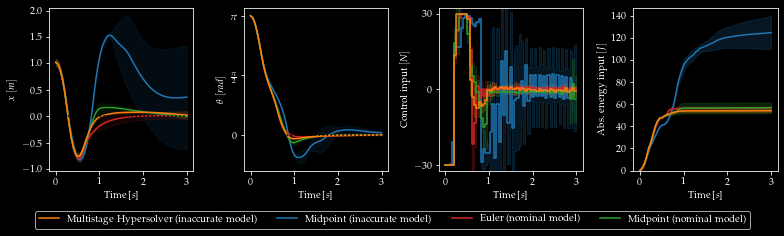

In [20]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

plt.style.use('dark_background')


from math import pi as π

experiments = ['MidpointInaccurate', 'EulerAccurate', 'MidpointAccurate', 'MultistageHypersolver']
colors = {'MidpointInaccurate': 'tab:blue', 'MultistageHypersolver': 'tab:orange', 'EulerAccurate':'tab:red', 'MidpointAccurate': 'tab:green'}
labels = {'MidpointInaccurate': 'Midpoint (inaccurate model)', 'MultistageHypersolver': 'Multistage Hypersolver (inaccurate model)', 'EulerAccurate':'Euler (nominal model)', 'MidpointAccurate': 'Midpoint (nominal model)'}
linestyles = {'MidpointInaccurate': '-', 'MultistageHypersolver': '-', 'EulerAccurate':'-', 'MidpointAccurate': '-'}
trajectories = [trajectories_mp_inac, trajectories_eu_ac, trajectories_mp_ac, trajectories_hs]
controls = [controls_mp_inac, controls_eu_ac, controls_mp_ac, controls_hs]

alpha = .1

fig, axs = plt.subplots(1, 4, figsize=(11, 3))

for exp, traj, control in zip(experiments, trajectories, controls):
    # Trajectories
    traj = skip_points(torch.stack(traj))
    
    t_m, t_s = traj.mean(0).detach(), traj.std(0).detach()
    tm0, tm1, tm2, tm3 = t_m[..., 0], t_m[..., 1], t_m[..., 2], t_m[..., 3]
    ts0, ts1, ts2, ts3 = t_s[..., 0], t_s[..., 1], t_s[..., 2], t_s[..., 3]
    t_span = torch.linspace(0, 3, len(tm0))
    axs[0].plot(t_span, tm0, color=colors[exp], label=labels[exp], linestyle=linestyles[exp])
    axs[1].plot(t_span, tm2, color=colors[exp], label=labels[exp], linestyle=linestyles[exp])
    axs[0].fill_between(t_span, tm0 - ts0, tm0 + ts0, alpha=alpha,  color=colors[exp])
    axs[1].fill_between(t_span, tm2 - ts2, tm2 + ts2, alpha=alpha,  color=colors[exp])

    # Controls
    control = torch.stack(control).squeeze()
    cmean, cstd = control.mean(0), control.std(0)
    t_span = torch.linspace(0, 3, len(tm))
    axs[2].step(t_span, cmean, color=colors[exp])
    axs[2].fill_between(t_span, cmean - cstd, cmean + cstd, color=colors[exp],step='pre', alpha=0.2)
    
    # Work: calculate absolute work done by the controller
    # Energy = power x dt = force x velocity x dt
    abs_energy = abs(traj[..., 1] * control * 0.05)
    work = torch.zeros_like(abs_energy)
    for i in range(abs_energy.shape[1]):
        work[:, i] = abs_energy[:, :i+1].sum(1)
    te_mean, te_std = work.mean(0).detach().squeeze(), work.std(0).detach().squeeze()
    t_span = torch.linspace(0, 3, len(te_mean))
    axs[3].plot(t_span, te_mean, color=colors[exp])
    axs[3].fill_between(t_span, te_mean - te_std, te_mean + te_std, color=colors[exp], alpha=0.2)

axs[0].plot(t_span, torch.zeros(len(t_span)), 'k:', label = 'Target')
axs[1].plot(t_span, torch.zeros(len(t_span)),'k:', label = 'Target')
axs[1].set_yticks([0, π/2, π], [r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])

axs[2].set_yticks([-30, 0, 30])
axs[2].set_ylim([-32, 32])

axs[3].set_ylim(0)

axs[0].set_xlabel('Time [$s$]'), axs[0].set_ylabel(r'$x~[m]$')
axs[1].set_xlabel('Time [$s$]'), axs[1].set_ylabel(r'$\theta~[rad]$')
axs[2].set_xlabel('Time [$s$]'), axs[2].set_ylabel(r'Control input $[N]$')
axs[3].set_xlabel('Time [$s$]'), axs[3].set_ylabel(r'Abs. energy input $[J]$')
plt.tight_layout()

handles, labels = axs[0].get_legend_handles_labels()
order = [3,0,1,2] # reorder to get Multistage first
fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.1))

fig.savefig('media/cartpole_control.png',  bbox_inches = 'tight')

import tikzplotlib
tikzplotlib.save("media/cartpole_control.tex")